<a href="https://colab.research.google.com/github/DanielDialektico/Machine-Learning/blob/main/Modelado%20de%20t%C3%B3picos/LDA_Modelado_de_T%C3%B3picos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este espacio de trabajo contiene la aplicación de un algoritmo de aprendizaje no supervisado de procesamiento de lenguaje natural a un conjunto de datos de reseñas de clientes de una tienda departamental. 

El modelo utilizado fue el LDA ()Latent Dirichlet Allocation), el cual se utiliza para modelado de tópicos, es decir, agrupación de términos en categorías (permite superposición de términos, es decir, cada término puede estar asociado a más de una clase).


# Carga de datos

En el siguiente fragmento de código se instalan y cargan las librerías necesarias.

In [37]:
!python3 -m spacy download es_core_news_sm
!pip install pyLDAvis
!pip install pyLDAvis.gensim
import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
import pandas as pd
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import es_core_news_sm
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
nltk.download('punkt')

#Se ignoran las alertas.
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-28 07:34:21.272288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 07:34:21.272480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 07:34:21.272506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


En el siguiente bloque se carga y filtra el conjunto de datos:

In [38]:
#Se carga el conjunto de datos.
reviews = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Conjuntos%20de%20datos/Rese%C3%B1as.csv')
reviews = reviews["Opinión"].dropna().reset_index(drop = True)

# Exploración de datos

Se procede a graficar las 20 palabras más frecuentes.

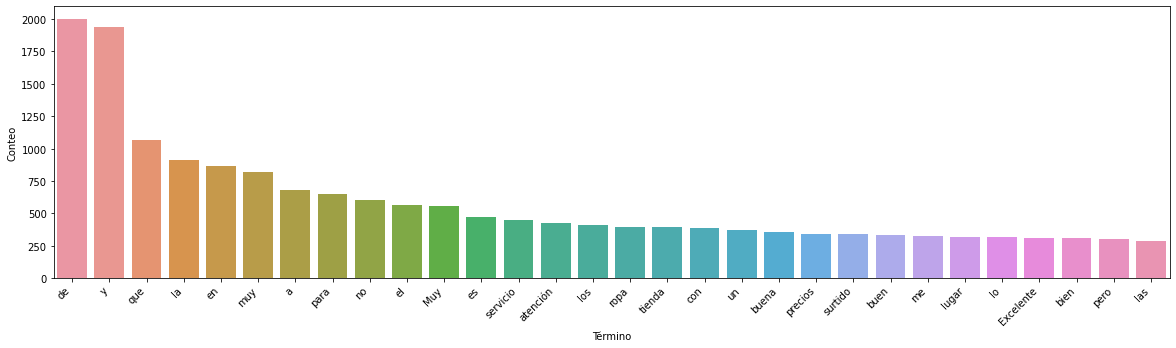

In [43]:
# Función para graficar términos más frecuentes
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Conteo')
  ax.set(xlabel = 'Término')
  plt.xticks(rotation=45, ha="right")
  plt.show()

freq_words(reviews)  

Dado que las palabras más frecuentes no aportan información relevante sobre las opiniones de los clientes, se procede a preprocesar el conjunto de datos.

# Preprocesamiento

En la siguiente celda se preprocesa el conjunto de datos aplicando los siguientes ajustes:



*   Se tokenizan las frases.
*   Se convierten todas las letras a minúsculas.
*   Se quitan caracteres no alfanuméricos.
*   Se eliminan stop words.
*   Se remueven adjetivos.
*   Se lematizan los textos.
*   Se remueven los acentos ortográficos.

Al final, se vuelven a graficar los términos más frecuentes.

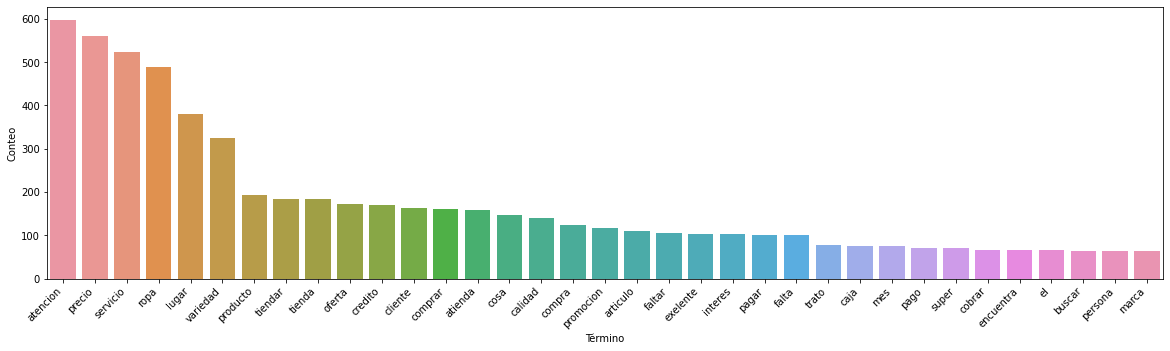

In [44]:
nlp = es_core_news_sm.load()

def remove_w(data_set):
  words = ["google", "traducción", "jeje", "gustar", "despota", "tener"]
  for i in words:
    data_set = data_set.str.replace(i, "")
  return data_set  

#reviews = remove_w(reviews)

drop_index = []

for i in range(len(reviews)):
  text = nlp(reviews.iloc[i])
  words = [t.orth_ for t in text if not t.is_punct | t.is_stop] 
  lexical_tokens = nlp(' '.join([t.lower() for t in words if len(t) > 3 and t.isalpha()]).replace("tender ","tienda "))
  lemmas_no_pron = ' '.join([tok.lemma_ for tok in lexical_tokens if tok.pos_ != 'PRON' and tok.pos_ != 'ADJ'])
  reviews.iat[i] = lemmas_no_pron
  lemmas_as_word = ' '.join(lemmas_no_pron)
  if lemmas_as_word == '':
    drop_index.append(i)
    
reviews = reviews.drop(drop_index)

reviews = remove_w(reviews)
reviews = reviews.str.replace("tender", "tienda")
reviews = reviews.str.replace("personar", "personal")
reviews = reviews.str.replace("preciar", "precio")
reviews = reviews.str.replace("mesar", "meses")


def remove_accent(data_set):
  accent = ["á","é","í","ó","ú"]
  drop_accent = ["a", "e", "i", "o", "u"]
  for i in range(len(accent)):
    data_set = data_set.str.replace(accent[i], drop_accent[i])
  return data_set  

reviews = remove_accent(reviews)

reviews = reviews.apply(lambda x: word_tokenize(x))

reviews_list = reviews.apply(lambda x: ' '.join([j for j in x]))
reviews_list = reviews_list.values.tolist()
freq_words(reviews_list, 35)

Ahora que se ha preprocesado el conjunto de datos, se aplica el algoritmo de aprendizaje no supervisado para la agrupación de términos en categorías.

El siguiente código ajusta el modelo a los datos, e imprime los principales términos que componen a cada una de las 4 categorías generadas.

In [45]:
dictionary = corpora.Dictionary(reviews)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews]

LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state = 100,
                chunksize=100, passes=50)

lda_model.print_topics()

[(0,
  '0.137*"atencion" + 0.077*"variedad" + 0.043*"producto" + 0.041*"credito" + 0.038*"cliente" + 0.033*"cosa" + 0.026*"compra" + 0.022*"faltar" + 0.019*"encuentra" + 0.017*"super"'),
 (1,
  '0.140*"precio" + 0.130*"servicio" + 0.098*"lugar" + 0.047*"tiendar" + 0.037*"comprar" + 0.025*"articulo" + 0.025*"calidad" + 0.024*"interes" + 0.020*"cobrar" + 0.013*"mes"'),
 (2,
  '0.057*"tienda" + 0.041*"oferta" + 0.030*"promocion" + 0.029*"trato" + 0.025*"exelente" + 0.020*"pago" + 0.018*"estacionamiento" + 0.016*"poder" + 0.015*"centro" + 0.014*"encontrar"'),
 (3,
  '0.141*"ropa" + 0.052*"atienda" + 0.036*"falta" + 0.026*"caja" + 0.019*"gente" + 0.016*"familia" + 0.014*"vender" + 0.014*"amabl" + 0.012*"ubicacion" + 0.011*"pagar"')]

Por último, se visualizan los resultados:

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.294688  0.135957       1        1  28.018274
1      0.231285  0.207711       2        1  25.703342
2      0.002904 -0.222514       3        1  23.972498
3      0.060498 -0.121154       4        1  22.305886, topic_info=              Term        Freq       Total Category  logprob  loglift
21          precio  481.000000  481.000000  Default  30.0000  30.0000
3         atencion  511.000000  511.000000  Default  29.0000  29.0000
2             ropa  420.000000  420.000000  Default  28.0000  28.0000
1         servicio  446.000000  446.000000  Default  27.0000  27.0000
18           lugar  335.000000  335.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
377       telefono   13.504703   14.280946   Topic4  -5.3941   1.4444
1109     necesidad   12.574158   13.307987   Topic4  -5.4655   1.4436
93           pagar   33.488032   66.462691   Topic4  -4.4860   0.8149
216   departamento   18.811260   32.273642   Topic4  -5.0627   0.9605
76         calidad   30.208596  114.772284   Topic4  -4.5890   0.1655

[158 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
88        2  0.948832       abono
740       3  0.971429       abrir
431       4  0.941437  amabilidad
96        4  0.987517       amabl
124       2  0.934605    ambiente
...     ...       ...         ...
469       4  0.910083      vestir
502       1  0.942792      volver
487       2  0.926977    zapateer
157       1  0.990892      zapato
644       3  0.950365        zona

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])